# Multidimensional scaling algorithm

## Import Libraries

In [1]:
# import libraries
import numpy as np
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.figsize'] = (6.5, 6.5)

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d

# plotting style
#plt.style.use('classic')
#plt.style.use('dark_background')
#plt.style.use('bmh')

import seaborn as sns

from IPython.display import Image

# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";

import warnings
warnings.filterwarnings('ignore');

## Intro

Multidimensional scaling is an algorithm used for dimensionality reduction and manifold learning. In some ways it was the earliest developed method, with broad applications for high dimensional data in genetics, psychology, sociology, political science, ecology, and many other domains related to modeling structural relationships between objects and conveying their similarities spatially [<sup>1</sup>](#fn1). <br>

![title](mds_psych.gif)
The figure shows an application of multidimensional scaling in clinical psychology - the spatial representation illustrates dimensions of repetitive thought. The horizontal axis 'Valence' reflects whether the content of thoughts is positive or negative. The vertical axis 'Purpose' reflects whether the tone of thoughts is searching, questioning, and/or uncertain (negative numerical values) or largely solving, planning, and/or certain (positive numerical values). Notice that similar types are close together (self-analysis, reflection) and dissimilar types are further apart (reminiscing, worry) <br>
https://www.apa.org/science/about/psa/2011/03/repetitive-thought

![title](mds_pol.png)
MDS applied to voting patterns of Democratics/Republicans in US House of Representatives

## Python MDS examples

Given a dataset of any dimensionality, Multidimensional scaling (MDS) attempts to project the data to lower dimensions in a way that preserves the pairwise distances of the data points. Here is an example that demonstrates MDS:

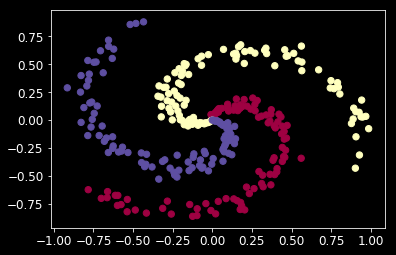

In [76]:
# spiral dataset from http://cs231n.github.io/neural-networks-case-study/
plt.style.use('dark_background')
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show();

The structure of the data is more accurately represented as the pairwise distance matrix, since scaling, rotation, and translations don't necessarily change the structure of this dataset.

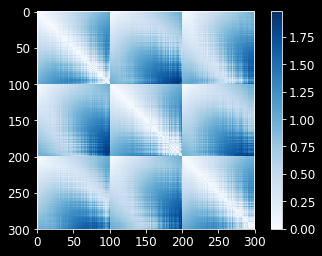

In [65]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
plt.imshow(D, cmap='Blues', interpolation='nearest')
plt.colorbar();

Now we linearly project the data into 3 dimensions

In [67]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(300, 3)

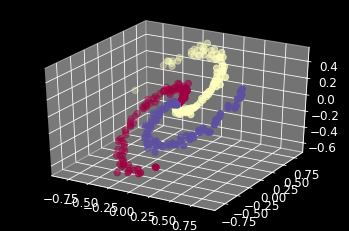

In [68]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], c=y, s=40, cmap=plt.cm.Spectral);

MDS can map this 3D data into 2D in a way that nicely recovers the original 2D data

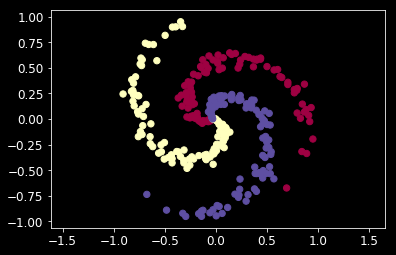

In [8]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.axis('equal');

MDS isn't able to recover the data as well under a non-linear projection

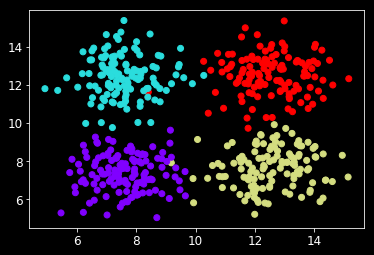

In [70]:
from sklearn.datasets import make_blobs
plt.style.use('dark_background')
x, y = make_blobs(n_samples=500, centers=[[7.5, 7.5], [7.5, 12.5], [12.5, 7.5], [12.5, 12.5]], cluster_std=1)
plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.rainbow);

We define a function that projects the data into 3D with the following 'swiss roll' transformation

In [73]:
def make_swiss_roll(X):
    x = X[:, 0]*np.cos(X[:, 0])
    y = X[:, 1]
    z = X[:, 0]*np.sin(X[:, 0])
    return np.vstack((x, y, z)).T

XS = make_swiss_roll(X)

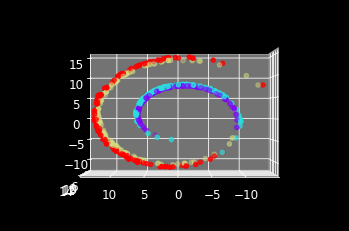

In [74]:
XS = make_swiss_roll(x)
from mpl_toolkits import mplot3d
plt.subplot(2, 1, 1)
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], c=y, cmap=plt.cm.rainbow)
ax.view_init(0, 90);
#plt.subplot(2, 1, 2)
#ax = plt.axes(projection='3d')
#ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], c=y, cmap=plt.cm.rainbow)

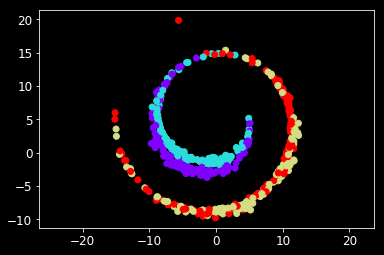

In [60]:
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], c=y, cmap=plt.cm.rainbow)
plt.axis('equal');

Here MDS merely flattens the data onto the yz-plane and isn't able to represent the original structure of our original clustered data. <br>
<br>
As we will see, MDS attempts to preserve global distances between all the pairs and this doesn't work as well for nonlinear embeddings. Local linear embedding works better by only considering linear relationships within small neighborhoods.

## The Algorithm

**Algorithm Outline**: <br>
<br>
Given a pairwise distance matrix $D$ with entries $d_{ij}$ for the distance between $X_i, X_j$, find $X_1, ..., X_n \in \mathbb{R}^p$ such that <br>
<br>
$$d_{ij} \approx ||X_{i} - X_{j}||^2$$
<br>
We find the coordinates that keep the Euclidean distance as close as possible to our original distances. <br>
<br>
**Note:** the original distances in $D$ do not have to be Euclidean distances. The algorithm will be slightly modified when the original distances are Euclidean vs. non-Euclidean.

### Classical MDS

When original distances are Euclidean, we use Classical Multidimensional Scaling

**Input**: $D$, n x n matrix with *Euclidean* pairwise distances <br>
**Output**: $X = [X_1, ..., X_n]$, coordinate positions of the observations <br>
<br>
**Steps**:
1. Compute matrix B with inner products <br>
2. Find coordinate positions from B

#### Step 1: Inner product matrix

The points that we output are defined as the rows of matrix $X = [X_1, ..., X_n]^T$,  where $X_1, ..., X_n \in \mathbb{R}^p$

If we solve for this $X$, then we also have solution $X^* = X + c$: <br>
<br>
$$
\begin{equation}
\begin{aligned}
d_{ij} & \approx ||X^*_{i} - X^*_{j}||^2\\
\\
            & = ||(X_{i} + c) - (X_{j} + c)||^2\\
\\
            & = ||X_{i} - X_{j}||^2\\
\end{aligned}
\end{equation}
$$

Any shift of the points by an arbitrary value of c are all solutions, so we just assume points are centered around zero. <br>
Stated as the constraint that the mean of each column (or the column sums) in $\mathbb{R}^p$ is zero:  <br>
$$\sum_{i=1}^n X_{ik} = 0, \ \ \text{for all k}$$

To find the matrix $X$ with the output coordinates, we use the n x n Gram matrix $B$ with the inner products:

$B = X X^T$ <br>
<br>
(n x p) * (p x n) = n x n matrix

We have <br>
<br>
$$\mathbf{X X^T} = \begin{bmatrix}
X_{1_1} & X_{1_2} & \cdots & X_{1_p} \\
X_{2_1} & X_{2_2} & \cdots & X_{2_p} \\
\vdots & \vdots & \vdots & \vdots \\
X_{n_1} & X_{n_2} & \cdots & X_{n_p}
\end{bmatrix} 
\begin{bmatrix}
X_{1_1} & X_{2_1} & \cdots & X_{n_1} \\
X_{1_2} & X_{2_2} & \cdots & X_{n_2} \\
\vdots & \vdots & \vdots & \vdots \\
X_{1_p} & X_{2_p} & \cdots & X_{n_p}
\end{bmatrix}$$ <br>
<br>

The entries are given by $b_{ij} = \langle X_i , X_j \rangle = \sum_{k=1}^p X_{ik} X_{jk}$

and we relate this to distance $d_{ij}$ <br>
$$
\begin{equation}
\begin{aligned}
d_{ij}^2 & = ||X_i - X_j||^2\\
\\
            & = \sum_{k} (X_{ik} - X_{jk})^2\\
\\
            & = \sum_{k} X_{ik}^2 - 2 \sum_{k} X_{ik} X_{jk} + \sum_{k} X_{jk}^2\\
\\
            & = b_{ii} - 2 b_{ij} + b_{jj}\\
\end{aligned}
\end{equation}
$$

If we have column means of $X = 0$, then since B is symmetric the column means and row means of $B = 0$. The matrix B is "double centered".

From the previous constraint of centering $X$ around 0: <br>
$$\sum_{i=1}^n X_{ik} = 0, \ \ \text{for all k}$$
<br>
and so with $b_{ij} = \langle X_i , X_j \rangle = \sum_{k=1}^p X_{ik} X_{jk}$ we have column sums:
$$
\begin{equation}
\begin{aligned}
\sum_{i=1}^n b_{ij} & = \sum_{i=1}^n \sum_{k=1}^p X_{ik} X_{jk} \\
\\
            & = \sum_{k=1}^p X_{jk} \sum_{i=1}^n X_{ik} \\
\\
            & = 0 \ \ \ \text{for j = 1,...,n}\\
\end{aligned}
\end{equation}
$$

Hence, the sum of each column of $B = 0$. Since $B$ is symmetric, the row sums are also equal to zero.

Therefore from $d_{ij}^2 = b_{ii} + b_{jj} - 2 b_{ij}$ we have: <br>
<br>
$$
\begin{equation}
\begin{aligned}
1.) \ \sum_{i=1}^n d_{ij}^2 & = \sum_{i=1}^n b_{ii} + n b_{jj} - 2 \sum_{i=1}^n b_{ij} \\
\\
            & = tr(B) + n b_{jj} + 0 && (\text{by result of double centering around 0)}\\
\\
            & = tr(B) + n b_{jj}\\
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
2.) \ \sum_{j=1}^n d_{ij}^2 & = n b_{ii} + \sum_{j=1}^n b_{jj} - 2 \sum_{i=1}^n b_{ij} \\
\\
            & = tr(B) + n b_{ii} + 0 && (\text{by result of double centering around 0)}\\
\\
            & = tr(B) + n b_{ii}\\
\end{aligned}
\end{equation}
$$

$$
\begin{equation}
\begin{aligned}
3.) \ \sum_{j=1}^n \sum_{i=1}^n d_{ij}^2 & = \sum_{j=1}^n \sum_{i=1}^n b_{ii} + \sum_{i=1}^n \sum_{j=1}^n b_{jj} - 2 \sum_{j=1}^n \sum_{i=1}^n b_{ij} \\
\\
            & = n tr(B) + n tr(B) + 0 && (\text{by result of double centering around 0)}\\
\\
            & = 2n tr(B)\\
\end{aligned}
\end{equation}
$$

Finally, we combine the previous results to get the closed form of matrix B <br>
<br>
$$
\begin{equation}
\begin{aligned}
b_{ij} & = -\frac{1}{2} (d_{ij}^2 - b_{ii} - b_{jj}) \\
\\
            & = -\frac{1}{2} (d_{ij}^2 - \frac{1}{n}\sum_{i=1}^n d_{ij}^2 - \frac{1}{n}\sum_{j=1}^n d_{ij}^2 + \frac{1}{n^2}\sum_{j=1}^n \sum_{i=1}^n d_{ij}^2) \\
\\
            & = -\frac{1}{2} (d_{ij}^2 - (\frac{1}{n} (tr(B) + n b_{jj} + tr(B) + n b_{ii} - 2 tr(B))) \\
\\
            & = -\frac{1}{2} (d_{ij}^2 - b_{ii} - b_{jj}) \\
\end{aligned}
\end{equation}
$$

For each j, $d_{\cdot j}^2$ = average of $d_{ij}^2, i=1,...,n$ (column means) <br>
For each i, $d_{i \cdot}^2$ = average of $d_{ij}^2, j=1,...,n$ (row means) <br>
For i,j, $d_{\cdot \cdot}^2$ = average of $d_{ij}^2, i, j = 1,...,n$ (overall mean)

$$\boxed {B = \frac{-1}{2} C D_{2} C^T}$$ <br>
<br>
$C$ = centering matrix, $D_2$ = matrix with entries ${d_{ij}^2}$ 

#### Step 2: Find coordinate positions

We can now use the eigendecomposition of B: <br>
$$B = V \Lambda V^T = X X^T$$
<br>
and so $$ \boxed{X = \Lambda^\frac{1}{2} V^T}$$ 

We can reduce the dimensionality to $q \leq p$: <br>
$$ \boxed{X_{q} = \Lambda_{q}^\frac{1}{2} V_{q}^T}$$

by choosing the first q columns of V where $\Lambda_{q}$ is the first q x q submatrix

### Metric/non-metric MDS

___
## Notes
<span id="fn1"> **1:**</span>
Perhaps the most fascinating discussion of Multidimensional scaling comes from the cognitive scientist RN Shepard, who proposed a 'Universal law of generalization' to describe perception and mental representations in terms of an underlying mathematical structure, such that the universal laws governing the universe might be reflected in laws that govern conscious minds. He states "Invariance of the laws is achieved by constructing the representational spaces from psychological rather than physical data (using multidimensional scaling) and from considerations of geometry, group theory, and symmetry" (RN Shepard 2004). Shepard also says "These empirical regularities are mathematically derivable from universal principles of natural kinds and probabilistic geometry that may, through evolutionary internalization, tend to govern the behaviors of all sentient organisms" (RN Shepard 1987) <br>
<br>
Shepard tones - http://techchannel.att.com/play-video.cfm/2011/10/10/AT&T-Archives-A-Pair-of-Paradoxes